<img src="https://github.com/dahi84/BigData21/blob/branch_4/Lab_4/IMG/dask_horizontal.svg?raw=1"  width="30%">



# Introduction to DASK
Dask is a parallel computing library that scales the existing Python ecosystem. This tutorial will introduce Dask and parallel data analysis more generally.

Dask can scale down to your laptop laptop and up to a cluster.


*  **High level Interface:**  Dask provides high-level Array, Bag, and DataFrame
   collections that mimic NumPy, lists, and Pandas but can operate in parallel on
   datasets that don't fit into memory.  Dask's high-level collections are
   alternatives to NumPy and Pandas for large datasets.

*  **Low Level Interface:** Dask provides dynamic task schedulers that
   execute task graphs in parallel.  These execution engines power the
   high-level collections mentioned above but can also power custom,
   user-defined workloads.  These schedulers are low-latency (around 1ms) and
   work hard to run computations in a small memory footprint.  Dask's
   schedulers are an alternative to direct use of `threading` or
   `multiprocessing` libraries in complex cases or other task scheduling
   systems like `Luigi` or `IPython parallel`.
   
## DASK Ressources 
*  [DASK Website](http://dask.org)
*  [Documentation](https://dask.pydata.org/en/latest/)


# High Level Interfaces: Parallelizing NumPy and Pandas

## Pandas
Pandas Dataframes are a very popular tool that provide full speadsheet and in-memory database functionality for the ***Python*** ecco system. It has become one of tstandard tools in Data Science and is also widely used for pre-processing / data wrangling tasks in machine learning

* the ***DASK*** API for ***Pandas*** is analog to the one for ***NumPy*** and will not be discussed here, see https://docs.dask.org/en/latest/dataframe.html for details.

## NumPy
As seen before, NumPy arrays are the dominat array and matrix data structure in the ***Python*** data science and machine learning ecco system.
* refresh your NumPy skills with this extra [tutorial](Extra_Material/Numpy.ipynb)

### Functionality of Dask arrays

* Arithmetic and scalar mathematics: +, *, exp, log, ...
* Reductions along axes: sum(), mean(), std(), sum(axis=0), ...
* Tensor contractions / dot products / matrix multiply: tensordot
* Axis reordering / transpose: transpose
* Slicing: x[:100, 500:100:-2]
* Fancy indexing along single axes with lists or NumPy arrays: x[:, [10, 1, 5]]
* Array protocols like __array__ and __array_ufunc__
* Some linear algebra: svd, qr, solve, solve_triangular, lstsq

**Full Array API: https://docs.dask.org/en/latest/array-api.html**

### Limitations
However, Dask Array does not implement the entire NumPy interface. Users expecting this will be disappointed. Notably, Dask Array lacks the following features:

* Much of np.linalg has not been implemented. This has been done by a number of excellent BLAS/LAPACK implementations, and is the focus of numerous ongoing academic research projects
* Arrays with unknown shapes do not support all operations
* Operations like sort which are notoriously difficult to do in parallel, and are of somewhat diminished value on very large data (you rarely actually need a full sort). Often we include parallel-friendly alternatives like topk
* Dask Array doesn’t implement operations like tolist that would be very inefficient for larger datasets. Likewise, it is very inefficient to iterate over a Dask array with for loops
  
**DASK is still evolving ...**


## Just get started!

In [3]:
#let's parallelize a simple array opperations
import numpy as np
np_A = np.random.rand(10000,10000) #create random NumPy array
%time np_A.sum()

Wall time: 163 ms


49999840.627775155

In [13]:
#now in parallel 
import dask.array as da
da_A = da.from_array(np_A, chunks=(5000)) #create DASk array from existing NumPy array
res = da_A.sum() #tell dask to compute the sum of A

In [14]:
res

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

### Where is my result?
In a nutshell: ***DASK*** basically works like ***TensorFlow***:
* First, it builds an execution graph
* Then, we need to execute it by calling ``compute()``

In [15]:
#call compute
%time res.compute()

Wall time: 87.8 ms


49999840.627774976

### Why is this not faster?
Well, building the graph, parallelizing it and scheduling it's execution causes some overhead...
* probably, our problem was to small :-)


### What is happening at ``compute()`` ?


In [16]:
#have look at the actual compute graph build by DASK
res.visualize(filename='graph.svg')

RuntimeError: Drawing dask graphs requires the `graphviz` python library and the `graphviz` system library to be installed.

### Ahh - MapReduce!
* looks like ***DASK*** automatically implemented MapReduce
* but, why did it use 4 parallel paths?

### Block concept of DASK arrays
* ***DASK*** splitts arrays into blocks 
* parallelization (here MapReduce) runs over Blocks
* Blocks sizes are definde by the ``chunks`` 

```
#recall array creation
da_A = da.from_array(np_A, chunks=(5000))
```

<img SRC="IMG/array.png">

In [17]:
#get size of chucks
da_A.chunks

((5000, 5000), (5000, 5000))

In [18]:
da_A.chunksize

(5000, 5000)

In [19]:
#change chunk size
#WARNING: can be very expensive - better think about the chunk size before ...
B=da_A.rechunk(1000)

In [20]:
B.chunks

((1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000),
 (1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000))

In [21]:
res=B.sum()
graph=res.visualize(filename='graph.svg')#saving graph to file

RuntimeError: Drawing dask graphs requires the `graphviz` python library and the `graphviz` system library to be installed.

### Is this running in Parallel ?
* open ternminal
* start ``top``
* execute ``compute()``

In [22]:
%%timeit #measure mean of 10 runs
res.compute()

108 ms ± 9.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Memory Usage
By processing each block at a time, ***DASK*** is not only able tu run in parallel, but also needs only tthe memory for the bock size...
* allows easy processing of **larger than memory** data sets

In [23]:
#a larger example in NumPy
%time x = np.random.normal(10, 0.1, size=(20000, 20000)) 
%time y = x.mean(axis=0) #compute mean along first axis


Wall time: 21.1 s
Wall time: 1.27 s


In [24]:
#same in DASK
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0) 
%time res=y.compute() 

Wall time: 7.74 s


# Distributed Execution

In [25]:
from dask.distributed import Client #import distributed client

In our cluster enviroment, the ***DASK*** Cluster is automatically started for multi node jobs. See DASK documentation on how to setup a ***DASK*** cluster: http://distributed.dask.org/en/latest/setup.html

In [26]:
client = Client() # on a cluster, give MASTER IP -> client = Client(MASTER_IP)

In [27]:
#see how many workers we have
workers=client.scheduler_info()['workers']
for w in workers:
    print(w)

tcp://127.0.0.1:64292
tcp://127.0.0.1:64296
tcp://127.0.0.1:64301
tcp://127.0.0.1:64303


## Submit work to the Cluster

In [28]:
#simple remote functions
def square(x):
    return x ** 2

def neg(x):
    return -x

#using the map future, functions will be scheduled for execution - NO graph building and compute()
A = client.map(square, range(1000))
B = client.map(neg, A)

In [29]:
total = client.submit(sum, B)

In [30]:
res = total.result()
print ("done: ",res)

done:  -332833500


### Arrays on the Cluster
Starting a cluster client automatically cause the high level interfaces to use the cluster

In [31]:
import numpy as np
np_A = np.random.rand(10000,10000) #create random NumPy array
import dask.array as da
cluster_A = da.from_array(np_A, chunks=(5000)) #create DASk array from existing NumPy array
res = cluster_A.sum() #tell dask to compute the sum of A

In [32]:
%time res.compute()

Wall time: 1min 8s


49995672.195544474

# Using ***Scikit-Learn*** with ***Dask***
Note: This is quit new and under heavy development

In [33]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [34]:
#generate some random classification data
X, y = make_classification(n_samples=1000, random_state=0)
X[:5]

array([[-1.06377997,  0.67640868,  1.06935647, -0.21758002,  0.46021477,
        -0.39916689, -0.07918751,  1.20938491, -0.78531472, -0.17218611,
        -1.08535744, -0.99311895,  0.30693511,  0.06405769, -1.0542328 ,
        -0.52749607, -0.0741832 , -0.35562842,  1.05721416, -0.90259159],
       [ 0.0708476 , -1.69528125,  2.44944917, -0.5304942 , -0.93296221,
         2.86520354,  2.43572851, -1.61850016,  1.30071691,  0.34840246,
         0.54493439,  0.22532411,  0.60556322, -0.19210097, -0.06802699,
         0.9716812 , -1.79204799,  0.01708348, -0.37566904, -0.62323644],
       [ 0.94028404, -0.49214582,  0.67795602, -0.22775445,  1.40175261,
         1.23165333, -0.77746425,  0.01561602,  1.33171299,  1.08477266,
        -0.97805157, -0.05012039,  0.94838552, -0.17342825, -0.47767184,
         0.76089649,  1.00115812, -0.06946407,  1.35904607, -1.18958963],
       [-0.29951677,  0.75988955,  0.18280267, -1.55023271,  0.33821802,
         0.36324148, -2.10052547, -0.4380675 , -

In [35]:
# SKlearn Hyper-Parameter Search
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           n_jobs=-1)

In [36]:
%time grid_search.fit(X, y)


Wall time: 10.2 s


GridSearchCV(cv=3,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]})

In [37]:
#noe map this to the cluster
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

%time
with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)

C:\Users\danie\Anaconda3\lib\site-packages\distributed\dashboard\core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [WinError 10048] Normalerweise darf jede Socketadresse (Protokoll, Netzwerkadresse oder Anschluss) nur jeweils einmal verwendet werden
  warnings.warn("\n" + msg)


Wall time: 0 ns


In [38]:
#get results back
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.284589,0.029813,0.023601,0.004770,0.001,rbf,True,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': True}",0.502994,0.501502,0.501502,0.501999,0.000704,41
1,0.284422,0.010559,0.036741,0.027643,0.001,rbf,False,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': False}",0.502994,0.501502,0.501502,0.501999,0.000704,41
2,0.211796,0.030141,0.014960,0.003550,0.001,poly,True,"{'C': 0.001, 'kernel': 'poly', 'shrinking': True}",0.502994,0.501502,0.501502,0.501999,0.000704,41
3,0.237240,0.014863,0.011969,0.001410,0.001,poly,False,"{'C': 0.001, 'kernel': 'poly', 'shrinking': Fa...",0.502994,0.501502,0.501502,0.501999,0.000704,41
4,0.327327,0.017364,0.025769,0.012821,0.001,sigmoid,True,"{'C': 0.001, 'kernel': 'sigmoid', 'shrinking':...",0.502994,0.501502,0.501502,0.501999,0.000704,41
5,0.276465,0.016534,0.021942,0.004954,0.001,sigmoid,False,"{'C': 0.001, 'kernel': 'sigmoid', 'shrinking':...",0.502994,0.501502,0.501502,0.501999,0.000704,41
6,0.279274,0.033183,0.021608,0.007389,0.01,rbf,True,"{'C': 0.01, 'kernel': 'rbf', 'shrinking': True}",0.502994,0.501502,0.501502,0.501999,0.000704,41
7,0.383668,0.062790,0.044717,0.031779,0.01,rbf,False,"{'C': 0.01, 'kernel': 'rbf', 'shrinking': False}",0.502994,0.501502,0.501502,0.501999,0.000704,41
8,0.301382,0.076791,0.025102,0.016315,0.01,poly,True,"{'C': 0.01, 'kernel': 'poly', 'shrinking': True}",0.508982,0.510511,0.504505,0.507999,0.002549,39
9,0.208126,0.029369,0.013963,0.002936,0.01,poly,False,"{'C': 0.01, 'kernel': 'poly', 'shrinking': False}",0.508982,0.510511,0.504505,0.507999,0.002549,39


# Low Level Interfaces: Parallelizing Compute Graphs
Building the Compute-Graph manually

In [43]:
# simple example
%%time
def inc(x):
    return x + 1

def double(x):
    return x + 2

def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)


UsageError: Line magic function `%%time` not found.


In [40]:
total

45

### **Now, build a graph:**
```dask.delayed()``` add functions and arguments to graph:

In [41]:
import dask

output = []
for x in data:
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

total = dask.delayed(sum)(output)


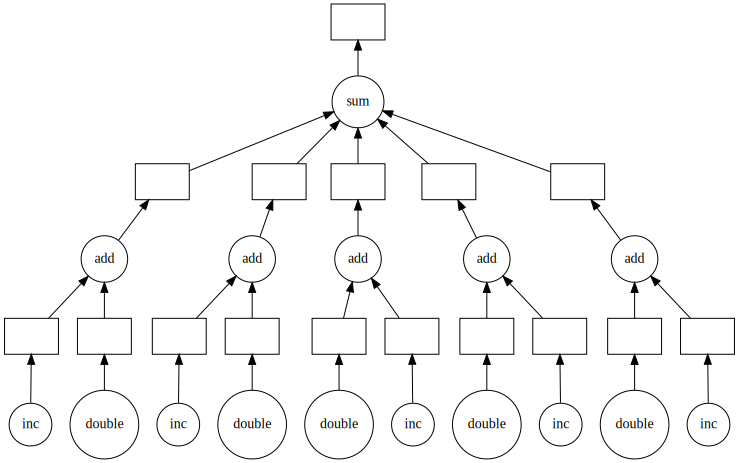

In [ ]:
total.visualize(filename="graph2.svg")

In [ ]:
#call copute to execute
%%time total.compute()

45